In [1]:
import pandas as pd
import seaborn as sb
import seaborn.objects as so
import utils as utils
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
%reload_ext autoreload
%autoreload 2

2023-04-30 20:34:44.203554: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 20:34:44.250360: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 20:34:44.251224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 20:34:45.153705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df=utils.get_df('data.csv')
sales=utils.get_df('sales.csv')
df=pd.concat([df, sales['saleamt']],axis = 1)
df=df.dropna(axis=0)
enc = LabelEncoder()
enc.fit(df['zipcode'])
df['zipcode']=enc.transform(df['zipcode'])
enc.fit(df['yearbuilt'])
df['yearbuilt']=enc.transform(df['yearbuilt'])
X_train, X_test, y_train, y_test = train_test_split(df[['yearbuilt','universalsize','beds','bathstotal','zipcode']],df['saleamt'], test_size=0.3)

HistGradientBoostingClassifier

In [11]:
#Decision Tree creatation
clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

predications = clf.predict(X_test)

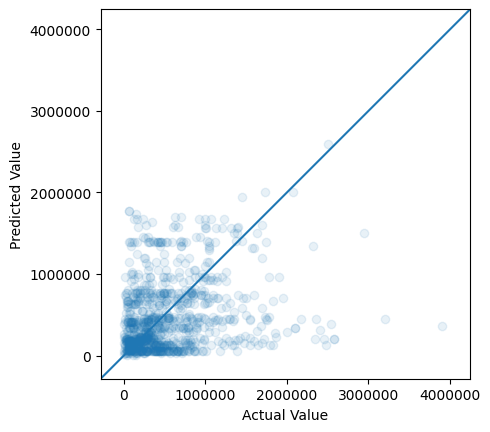

In [13]:
fig, ax=plt.subplots()
ax.scatter(x=y_test,y=predications,alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()])-2000000,  # max of both axes
]
ax.axline((0, 0), slope=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.ticklabel_format(useOffset=False,style="plain")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
fig.show()

Support Vector Machine

In [5]:
clf2=svm.LinearSVR(max_iter=1000000)
inNames=['yearbuilt','universalsize','beds','bathstotal','zipcode']
clf2.fit(X_train[inNames], y_train)

predications2 = clf2.predict(X_test[inNames])

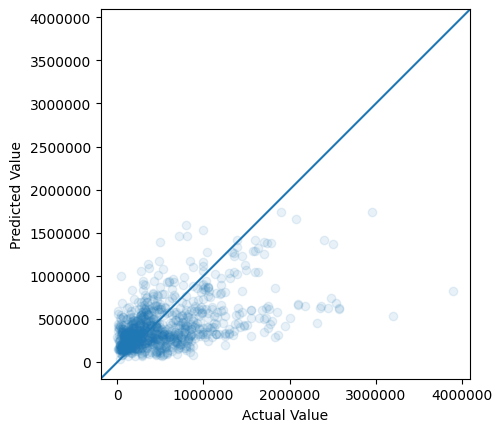

In [6]:
fig, ax=plt.subplots()
ax.scatter(x=y_test,y=predications2,alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline((0, 0), slope=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.ticklabel_format(useOffset=False,style="plain")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
fig.show()

Tensorflow Neural Network

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError as rms
from tensorflow.keras.metrics import MeanAbsoluteError as mae
from tensorflow.keras.optimizers import Adam


In [8]:
data=utils.get_df('data.csv')
sales=utils.get_df('sales.csv')
data=pd.concat([data, sales['saleamt']],axis = 1)
data=data[['yearbuilt','universalsize','beds','bathstotal','zipcode','saleamt']]
enc = LabelEncoder()
print(data.head(3))
enc.fit(data['zipcode'])
data['zipcode']=enc.transform(data['zipcode'])
enc.fit(data['yearbuilt'])
data['yearbuilt']=enc.transform(data['yearbuilt'])
print(data.head(3))
data=data.dropna(axis=0)
inNames=['yearbuilt','universalsize','beds','bathstotal','zipcode']
outNames=['saleamt']
normData, minVal, maxVal = utils.minNormalize(data)

train, val, test = utils.splitData(normData, seed=142)

# set hyperparams
# variables to tune
epochs = 1000
batch = 200
p = 10
nlayers = 6
mindelta = 1e-5
LR = 1e-4

# build the model
# build the model
model = utils.buildModel(nlayers,
                   metrics=[rms(), mae()],
                   optimizer=Adam(learning_rate=LR))

# fit the model
# stop the model if the validation loss levels off
cb = EarlyStopping(monitor='val_loss',
                   min_delta=mindelta,
                   patience=p,
                   restore_best_weights=True)

# reduce learning rate to try to improve results
lrCalib = ReduceLROnPlateau(monitor='val_loss',
                            factor=1e-2,
                            patience=5,
                            cooldown=5,
                            verbose=1)

# fit the model using the above two callbacks
hist = model.fit(train[inNames], train[outNames],
                 validation_data=(val[inNames], val[outNames]),
                 epochs=epochs,
                 batch_size=batch,
                 verbose=0,
                 callbacks=[cb, lrCalib])

# test with testing data
# predict with model and testing values
predNorm = model.predict(test[inNames])
pred = utils.inverseMinNormalize(predNorm, minVal, maxVal)
trueamt=utils.inverseMinNormalize(test[outNames], minVal, maxVal)


   yearbuilt  universalsize  beds  bathstotal  zipcode  saleamt
0     1984.0         2784.0   3.0         4.0    22066   882500
1     1976.0         1524.0   4.0         3.0    22066   770000
2     1989.0         5618.0   6.0         6.0    22066  1587500
   yearbuilt  universalsize  beds  bathstotal  zipcode  saleamt
0         91         2784.0   3.0         4.0        2   882500
1         83         1524.0   4.0         3.0        2   770000
2         96         5618.0   6.0         6.0        2  1587500

Epoch 83: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 92: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-09.

Epoch 101: ReduceLROnPlateau reducing learning rate to 9.999999939225291e-11.
13/13 [==============================] - 0s 1ms/step


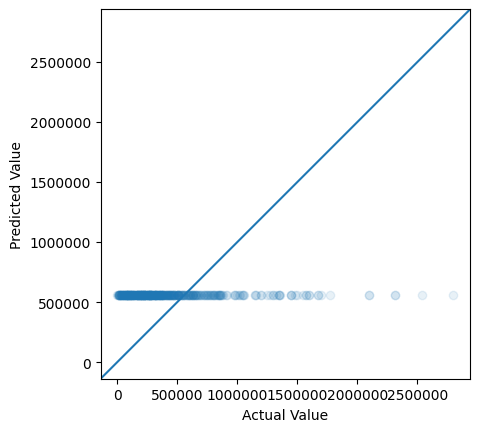

In [9]:
fig, ax=plt.subplots()
ax.scatter(x=trueamt,y=pred,alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline((0, 0), slope=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.ticklabel_format(useOffset=False,style="plain")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
fig.show()